## Imports

In [1]:
import os
import sys
import numpy as np
import time
import scipy
import matplotlib.pyplot as plt
import time
from scipy.stats import binned_statistic
from scipy.stats import binned_statistic_2d

In [2]:
# import the frank2d directory
current_dir =  os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
sys.path.append(parent_dir)

#frank2d
from frank2d import Frank2D
from constants import rad_to_arcsec
from plot import Plot
from fitting import IterativeSolverMethod

# frank1d
import frank
from frank.geometry import FixedGeometry, SourceGeometry, FitGeometryGaussian
from frank.radial_fitters import FrankFitter
from frank.utilities import UVDataBinner

### Functions

In [3]:
def deproject(u, v, inc, PA, inverse=False):
    r"""
    Deproject the image in visibily space

    Parameters
    ----------
    u : array of real, size = N, unit = :math:`\lambda`
        u-points of the visibilities
    v : array of real, size = N, unit = :math:`\lambda`
        v-points of the visibilities
    inc : float, unit = deg
        Inclination
    PA : float, unit = deg
        Position angle, defined east of north.
    inverse : bool, default=False
        If True, the uv-points are reprojected rather than deprojected

    Returns
    -------
    up : array, size = N, unit = :math:`\lambda`
        Deprojected u-points
    vp : array, size = N, unit = :math:`\lambda`
        Deprojected v-points
    wp : array of real, size = N, unit = :math:`\lambda`
        Fourier w-points of the deprojected visibilities. Only returned if
        deprojecting.

    """
    deg_to_rad = np.pi / 180
    inc *= deg_to_rad
    PA *= deg_to_rad

    cos_t = np.cos(PA)
    sin_t = np.sin(PA)

    if inverse:
        sin_t *= -1
        u = u / np.cos(inc)

    up = u * cos_t - v * sin_t
    vp = u * sin_t + v * cos_t

    if inverse:
        return up, vp
    else:
    #   Deproject
        wp = up * np.sin(inc)
        up = up * np.cos(inc)

        return up, vp, wp

In [4]:
 def apply_correction(self, u, v, V, use3D=False):
        r"""
        Correct the phase centre and deproject the visibilities

        Parameters
        ----------
        u : array of real, size = N, unit = :math:`\lambda`
            u-points of the visibilities
        v : array of real, size = N, unit = :math:`\lambda`
            v-points of the visibilities
        V : array of real, size = N, units = Jy
            Complex visibilites
        use3D : bool, default=False
            If True, also return the 3rd compoent of the
            de-projected visibilities, wp.

        Returns
        -------
        up : array of real, size = N, unit = :math:`\lambda`
            Corrected u-points of the visibilities
        vp : array of real, size = N, unit = :math:`\lambda`
            Corrected v-points of the visibilities
        wp : array of real, size = N, unit = :math:`\lambda`
            [Optional] Corrected w-points of the visibilities
        Vp : array of real, size = N, unit = Jy
            Corrected complex visibilites

        """
        Vp = apply_phase_shift(u, v, V, self._dRA, self._dDec, inverse=True)
        up, vp, wp = deproject(u, v, self._inc, self._PA)

        if use3D:
            return up, vp, wp, Vp
        else:
            return up, vp, Vp

In [5]:
def get_radial_profile(frank_object):
    x = frank_object._FT._Xn*rad_to_arcsec
    y = frank_object._FT._Yn*rad_to_arcsec
    pixel_size = (x[1]-x[0])
    r = np.hypot(x, y)
    I = frank_object.sol_intensity
    r = r.flatten()
    I = I.flatten()
    N = frank_object._Nx
    bin = (np.max(r) - np.min(r))/N
    I_binned, bin_edges, _ = binned_statistic(r, I, 'mean', N)
    r_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    return r_centers, I_binned

def get_vis_profile(frank_object):
    u = frank_object._FT._Un
    v = frank_object._FT._Vn
    pixel_size = (u[1]-u[0])
    q = np.hypot(u, v)
    Vis = frank_object.sol_visibility
    q = q.flatten()
    Vis = Vis.flatten()
    N = frank_object._Nx
    bin = (np.max(q) - np.min(q))/N
    weights_gridded = frank_object._gridded_data['weights']
    Vis_binned, bin_edges, _ = binned_statistic(q, Vis, 'mean', N)
    Vis_Weights_binned, bin_edges, _ = binned_statistic(q, Vis*weights_gridded, 'sum', N)
    Weights_binned, bin_edges, _ = binned_statistic(q, weights_gridded, 'sum', N)
    q_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    return q_centers, Vis_Weights_binned/Weights_binned

### Data

In [6]:
# Huang 2018 
inc = 34.97
pa = 85.76
dra = 1.9e-3
ddec = -2.5e-3
Rout = 2 #arcsecs

# UVtable
dir = "../../../data/"
data_file = dir +'AS209_continuum_prom_1chan_30s_keepflagsFalse.txt'

 # load data||
u, v, Re, Imag, Weights = np.loadtxt(data_file, unpack = True)
Vis = Re + Imag*1j

geom = SourceGeometry(inc= inc, PA= pa, dRA= dra, dDec= ddec)
u_deproj, v_deproj, vis_deproj = geom.apply_correction(u, v, Vis)

In [7]:
N = 300

In [8]:
frank2d = Frank2D(N, Rout, geometry = [inc, pa, dra, ddec])

In [9]:
import numpy as np

class FourierTransform2D(object):
    def __init__(self, Rmax, N):
        # Remember that now N is to create N**2 points in image plane.
        self._Xmax = Rmax #Rad
        self._Ymax = Rmax
        self._Nx = N 
        self._Ny = N
        self._N2 = self._Nx*self._Ny # Number of points we want to use in the 2D-DFT.

        # Real space collocation points
        self._x = np.linspace(-self._Xmax, self._Xmax, self._Nx, endpoint=False) # rad
        self._y = np.linspace(-self._Ymax, self._Ymax, self._Ny, endpoint=False) # rad
        x_, y_ = np.meshgrid(self._x, self._y, indexing='ij')
        # x_n.shape = N**2 X 1, so now, we have N**2 collocation points in the image plane.
        x_n, y_n = x_.reshape(-1), y_.reshape(-1)

        self._dx = 2*self._Xmax/self._Nx
        self._dy = 2*self._Ymax/self._Ny

        # Frequency space collocation points.
        self._u = np.fft.fftfreq(self._Nx, d = self._dx)[:self._Nx//2] # unshifted
        self._v = np.fft.fftfreq(self._Ny, d = self._dy) # unshifted
        u_, v_ = np.meshgrid(self._u, self._v, indexing='ij') 
        # u_n.shape = N**2 X 1, so now, we have N**2 collocation points.
        u_n, v_n = u_.reshape(-1), v_.reshape(-1)

        self._Xn = x_n
        self._Yn = y_n
        self._Un = u_n
        self._Vn = v_n

    def get_collocation_points(self):        
        return np.array([self.Xn, self.Yn]), np.array([self._Un, self._Vn])

    def coefficients(self, u = None, v = None, x = None, y = None, direction="forward"):
        #start_time = time.time()
        if direction == 'forward':
            ## Normalization is dx*dy since we the DFT to be an approximation
            ## of the integral (which depends on the area)
            norm = 4*self._Xmax*self._Ymax/self._N2
            factor = -2j*np.pi
            
            X, Y = self._Xn, self._Yn
            if u is None:
                u = self._Un
                v = self._Vn
        elif direction == 'backward':
            ## Correcting for the normalization above 1/N is replaced by this:
            norm = 1 / (4*self._Xmax*self._Ymax)
            factor = 2j*np.pi
            
            X, Y = self._Un, self._Vn
            if u is None:
                u = self._Xn
                v = self._Yn
        else:
            raise AttributeError("direction must be one of {}"
                                 "".format(['forward', 'backward']))
        H = norm * np.exp(factor*(np.outer(u, X) + np.outer(v, Y)))
        return H

    def fast_transform(self, element, direction = 'forward'):
        if direction == 'forward':
            return np.fft.fftshift(np.fft.fft2(element.reshape(self._Nx, self._Ny)).real)*(self._dx * self._dy)
        elif direction == 'backward':
            return np.fft.fftshift(np.fft.ifft2(element.reshape(self._Nx, self._Ny)).real)/(self._dx * self._dy)
        else:
            raise AttributeError("direction must be one of {}"
                                 "".format(['forward', 'backward']))
          
    def transform(self, element, direction = 'forward'):
        if direction == 'forward':
            F = self.coefficients(direction = 'forward')
            return F@element
        elif direction == 'backward':
            F_inverse = self.coefficients(direction = 'backward')
            return F_inverse@element
        else:
            raise AttributeError("direction must be one of {}"
                                 "".format(['forward', 'backward']))
    @property
    def size(self):
        """Number of points used in the 2D-DFT"""
        return self._N2

    @property
    def q(self):
        """Frequency points"""
        return np.hypot(self._Un, self._Vn)
    
    @property
    def Rmax(self):
        """ Maximum value of the x coordinate in rad"""
        return self._Xmax
    
    @property
    def resolution(self):
        """ Resolution of the grid in the x coordinate in rad"""
        return self._dx
    
    @property
    def xy_points(self):
        """ Collocation points in the image plane"""
        return self._Xn, self._Yn
    
    @property
    def uv_points(self):
        """u and v  collocation points"""
        return self._Un, self._Vn

In [10]:
frank2d._FT = FourierTransform2D(frank2d._Rmax, frank2d._Nx)

In [11]:
class HermitianGridding(object):
    def __init__(self, N, Rmax, FT):
        self._N = N
        self._Rmax = Rmax
        self._FT =  FT
        self._u = np.fft.fftfreq(FT._Nx, d = FT._dx) # unshifted
        self._v = np.fft.fftfreq(FT._Ny, d = FT._dy) 
        u_, v_ = np.meshgrid(self._u, self._v, indexing='ij') 
        u_n, v_n = u_.reshape(-1), v_.reshape(-1)
        self._Un = u_n
        self._Vn = v_n

    def run(self, u, v, Vis, Weights, type = 'weighted', shift = False): 
        # Calculating bin edges.
        bin_centers = self.edges_centers(self._u)[0]
        bin_edges_u = self.edges_centers(self._u)[1]
        bin_edges_v = self.edges_centers(self._v)[1]

        if type == 'weighted':
            u_gridded, v_gridded, vis_gridded, weights_gridded = self.weighted_gridding(u, v, Vis, Weights,
                                                                                        bin_centers, bin_edges_u, bin_edges_v, shift = shift)

        return u_gridded, v_gridded, vis_gridded, weights_gridded

    def edges_centers(self, freq):
        correction = (freq[1] - freq[0])/2
        
        # Creating the grid with shifted scheme.
        bin_centers = np.fft.fftshift(freq)
        edges_=  bin_centers - correction
        edges = np.concatenate((edges_, [edges_[-1] + 2*correction]))
        return bin_centers, edges
    
    def weighted_gridding(self, u, v, Vis, Weights, centers, edges_u, edges_v, shift = False):
        # calculating values in grid
        vis_weights_sum_bin, _, _, _ = binned_statistic_2d(u, v, Vis*Weights, 'sum', bins=[edges_u, edges_v], expand_binnumbers = False)
        weights_sum_bin, _, _, _ = binned_statistic_2d(u, v, Weights, 'sum', bins=[edges_u, edges_v], expand_binnumbers = False)
        vis_gridded_matrix =  vis_weights_sum_bin/weights_sum_bin
        weights_gridded_matrix, _, _, _ = binned_statistic_2d(u, v, Weights, 'sum', bins=[edges_u, edges_v], expand_binnumbers = False)

        # change Nans by 0 in vis.
        vis_gridded_ = np.nan_to_num(vis_gridded_matrix, nan=0)
        weights_gridded_ = np.nan_to_num(weights_gridded_matrix, nan=0)

        # Imposing hermitian conjugate property.
        vis_gridded, weights_gridded = self.enforce_hermitian_symmetry(vis_gridded_, weights_gridded_)

        if shift:
            u_gridded, v_gridded, vis_gridded, weights_gridded = self.shiftting(centers, vis_gridded, weights_gridded)
    
        else:
            u_gridded, v_gridded = self._Un, self._Vn # unshifted by default.
            vis_gridded = np.fft.fftshift(vis_gridded).flatten()
            weights_gridded = np.fft.fftshift(weights_gridded).flatten()

        vis_gridded_ = np.nan_to_num(vis_gridded_matrix, nan=0)
        weights_gridded_ = np.nan_to_num(weights_gridded_matrix, nan=0)

        return u_gridded, v_gridded, vis_gridded, weights_gridded

    def enforce_hermitian_symmetry(self, vis, weights):
        N_x, N_y = vis.shape
        vis_symmetric = vis.copy()
        weights_symmetric = weights.copy()
    
        center_x, center_y = N_x // 2, N_y // 2
    
        for i in range(center_x, N_x):  # Recorrer la mitad derecha
            for j in range(N_y):   
                i_sym = (2 * center_x - i) % N_x
                j_sym = (2 * center_y - j) % N_y
    
                v_uv = vis_symmetric[i, j]
                v_neg_uv = vis_symmetric[i_sym, j_sym]
    
                if np.abs(v_neg_uv.real) != np.abs(v_uv.real):
                    w_neg_uv = weights_symmetric[i_sym, j_sym]
                    w_uv = weights_symmetric[i, j]
                    w_final = w_neg_uv + w_uv
                    val = (np.conj(v_neg_uv)*w_neg_uv + v_uv*w_uv)/w_final
                    vis_symmetric[i, j] = val
                    vis_symmetric[i_sym, j_sym] = np.conj(val)
                    weights_symmetric[i, j] = w_final
                    weights_symmetric[i_sym, j_sym] = w_final
    
        return vis_symmetric, weights_symmetric

    def shiftting(self, freqs, vis_matrix, weights_matrix):
        vis_gridded = vis_matrix.flatten()
        weights_gridded = weights_matrix.flatten()
        u_, v_ = np.meshgrid(freqs, freqs, indexing='ij') 
        u_gridded, v_gridded = u_.reshape(-1), v_.reshape(-1)
        return u_gridded, v_gridded, vis_gridded, weights_gridded

In [41]:
Grid = HermitianGridding(N, frank2d._Rmax, frank2d._FT)

In [42]:
u_grid, v_grid, vis_grid, weights_grid = Grid.run(u_deproj, v_deproj, vis_deproj, Weights)

/var/folders/ng/vs__trg57hl3mtgq5kgkzj4h0000gn/T/ipykernel_38870/877969280.py:38: RuntimeWarning: invalid value encountered in divide
  vis_gridded_matrix =  vis_weights_sum_bin/weights_sum_bin


In [43]:
FT = frank2d._FT

In [44]:
x_labels = FT._u/1e6
y_labels = FT._v/1e6

num_ticks = 5
x_ticks_to_show = np.linspace(0, len(x_labels) - 1, num_ticks).astype(int)
y_ticks_to_show = np.linspace(0, len(y_labels) - 1, num_ticks).astype(int)

def format_labels(x):
    return f"{int(x):d}" if abs(x) > 1e-8 else "0"

In [45]:
new_vis = vis_grid.reshape(FT._Nx, FT._Ny).real[:, :FT._Ny //2]

In [35]:
new_vis.shape

(300, 150)

/var/folders/ng/vs__trg57hl3mtgq5kgkzj4h0000gn/T/ipykernel_38870/3443099374.py:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(new_vis)), vmin=-12, vmax=-2, origin= 'lower',cmap = 'plasma')


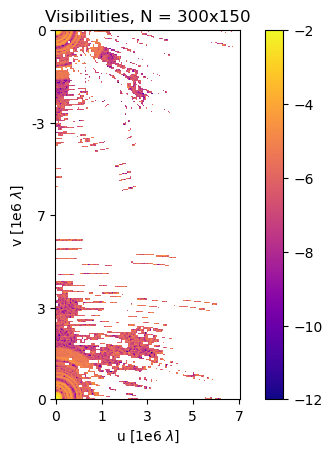

In [48]:
plt.imshow(np.log(np.abs(new_vis)), vmin=-12, vmax=-2, origin= 'lower',cmap = 'plasma')
plt.title(F'Visibilities, N = {N}x{N//2}')
plt.xticks(ticks=x_ticks_to_show, labels=[format_labels(x) for x in np.array(x_labels)[x_ticks_to_show]])
plt.yticks(ticks=y_ticks_to_show, labels=[format_labels(y) for y in np.array(y_labels)[y_ticks_to_show]])
plt.xlabel(r'u [1e6 $\lambda$]')
plt.ylabel(r'v [1e6 $\lambda$]')
plt.colorbar()

# Frank2D

In [19]:
N = 300

In [20]:
m, c, l = -0.33, -0.1, 2e5

In [21]:
vis_grid =  vis_grid.reshape(FT._Nx, FT._Ny)[:, :FT._Ny //2].flatten()
weights_grid = weights_grid.reshape(FT._Nx, FT._Ny)[:, :FT._Ny //2].flatten()

In [22]:
start_time = time.time()

#####

frank2d.set_gridded_data(u_grid, v_grid, vis_grid.real, weights_grid)
frank2d.set_kernel('Wendland', [m, c, l])
frank2d.fit(u, v, Vis, Weights, method = 'bicgstab', rtol = 1e-15, frank1d_guess = False, deproject = False)

#####
print("--------------------------------------")
end_time = time.time()
execution_time = end_time - start_time
print(f'time = {execution_time/60 :.2f}  min | {execution_time: .2f} seconds')

Setting gridded data...
Setting kernel: Wendland...
Gridding...
Setting fit with bicgstab ...
Setting guess... Visibilities gridded
Fitting...
  *  Constructing linear operators...
Setting A...
Setting A_precond...
Setting b...
     --> time = 2.39  min |  143.50 seconds
  *  Solving linear system...
     * BICGSTAB
         * rtol: 1e-15
         * final tolerance: 2.8060882479570498e-08
         * maxiter:  450000
             .. iteration:  0
             .. iteration:  1
             .. iteration:  2
             .. iteration:  3
             .. iteration:  4
             .. iteration:  5
             .. iteration:  6
             .. iteration:  7
             .. iteration:  8
             .. iteration:  9
             .. iteration:  10
             .. iteration:  11
             .. iteration:  12
             .. iteration:  13
             .. iteration:  14
             .. iteration:  15
             .. iteration:  16
             .. iteration:  17
             .. iteration:  18
 

In [23]:
vis_sol = frank2d.sol_visibility.reshape(FT._Ny, FT._Nx//2)
vis_sol.shape

(300, 150)

/var/folders/ng/vs__trg57hl3mtgq5kgkzj4h0000gn/T/ipykernel_38870/3805579792.py:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs((vis_sol.real))), vmin=-12, vmax=-2, origin = 'lower', cmap = 'plasma')


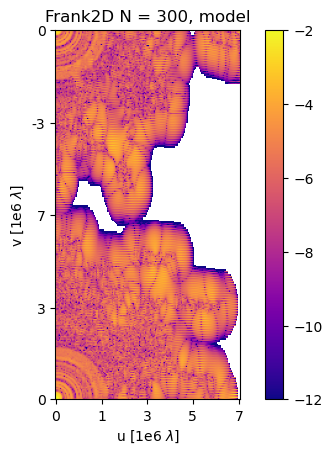

In [25]:
plt.imshow(np.log(np.abs((vis_sol.real))), vmin=-12, vmax=-2, origin = 'lower', cmap = 'plasma')
plt.title(F'Frank2D N = {N}, model')
plt.xticks(ticks=x_ticks_to_show, labels=[format_labels(x) for x in np.array(x_labels)[x_ticks_to_show]])
plt.yticks(ticks=y_ticks_to_show, labels=[format_labels(y) for y in np.array(y_labels)[y_ticks_to_show]])
plt.xlabel(r'u [1e6 $\lambda$]')
plt.ylabel(r'v [1e6 $\lambda$]')
plt.colorbar()

In [49]:
intensity_reduced = np.fft.fftshift(np.fft.irfft2(vis_sol, s=(FT._Nx, FT._Ny)))/(FT._dx * FT._dy)

In [50]:
frank2d.sol_intensity = intensity_reduced

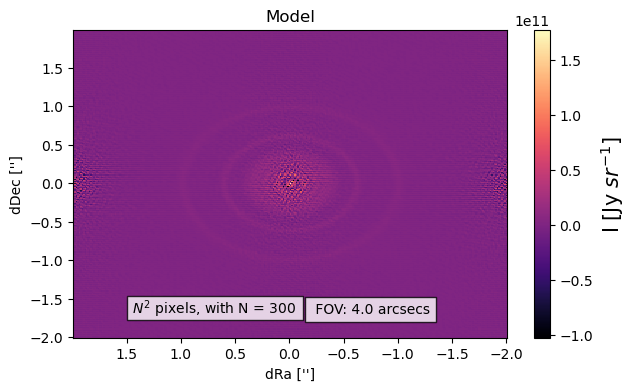

In [51]:
Plot(frank2d).get_image()

In [52]:
r, I = get_radial_profile(frank2d)

In [53]:
# Frank 1D Parameters
n_pts = 300
alpha = 1.3
w_smooth = 1e-1

geom = SourceGeometry(inc= inc, PA= pa, dRA= dra, dDec= ddec)
FF = FrankFitter(Rout, n_pts, geom, alpha = alpha, weights_smooth = w_smooth)
sol = FF.fit(u, v, Vis, Weights)

In [58]:
profile =  np.load(str(dir) + "radialProfile_F2D_AS209_1mm_n300pts_1p5e5.npz")
r2, I2 = profile['arreglo']

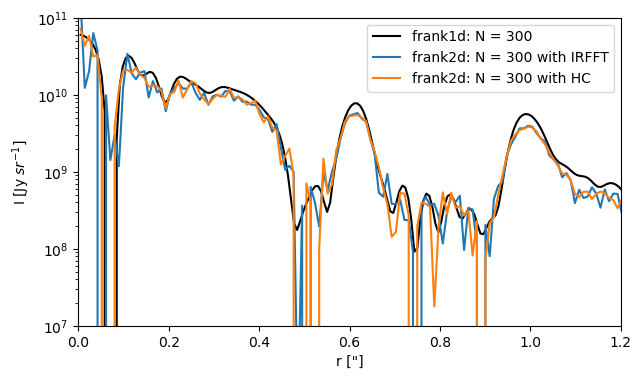

In [62]:
plt.figure(figsize=(7,4))
plt.plot(sol.r, sol.mean, 'black',label =f'frank1d: N = {n_pts}')
plt.plot(r, I, label = f'frank2d: N = {N} with IRFFT')
plt.plot(r2, I2, label = f'frank2d: N = {N} with HC')
plt.xlabel('r ["]')
plt.xlim(0, 1.2)      
plt.ylim(1e7, 1e11)
plt.ylabel(r'I [Jy $sr^{-1}$]')
plt.legend()
plt.yscale("log")
plt.show()

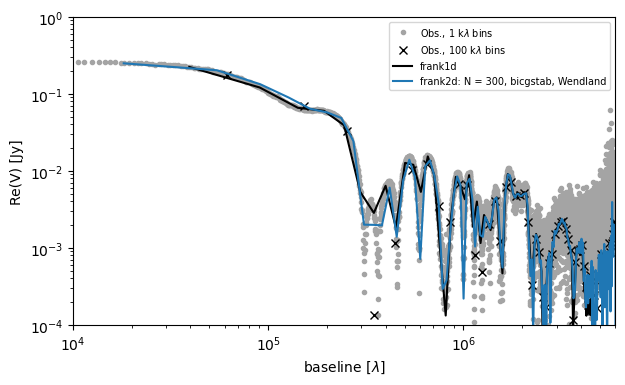

In [56]:
cs, ms = ['#a4a4a4', 'k'], ['.', 'x']
bin_widths=[1e3, 1e5]
baselines = np.hypot(u_deproj, v_deproj)         
grid = np.logspace(np.log10(min(baselines.min(), baselines[0])),
                           np.log10(max(baselines.max(), baselines[-1])),
                           10**4)

plt.figure(figsize=(7,4))

for i in range(len(bin_widths)):
            binned_vis = UVDataBinner(baselines, vis_deproj, Weights, bin_widths[i])
            plt.plot(binned_vis.uv, np.abs(binned_vis.V), c=cs[i],
                         marker=ms[i], ls='None', 
                         label=r'Obs., {:.0f} k$\lambda$ bins'.format(bin_widths[i]/1e3))


#frank1d
vis_fit_1d = sol.predict_deprojected(sol.q)
baselines_fit_1d = sol.q
plt.plot(baselines_fit_1d, np.abs(vis_fit_1d), color = "black", label = r'frank1d')

#frank2d
q, Vis_1= get_vis_profile(frank2d)
plt.plot(q, np.abs(Vis_1.real), label = f'frank2d: N = {N}, bicgstab, Wendland')

plt.xlabel(r'baseline [$\lambda$]')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-4, 1)
plt.xlim(1e4, 6e6)
plt.ylabel('Re(V) [Jy]', size = 10)
plt.legend(fontsize =7)
plt.show()

### Comparing with CLEAN

In [311]:
# Obtain the radial profiles convolved to a circular beam.
from gofish import imagecube

infile_1mm = dir + 'AS209_1mm_13s_conv_circ.fits'
#2D->1D
cube_1mm = imagecube(infile_1mm)
x_1mm,y_1mm,dy_1mm = cube_1mm.radial_profile(inc=inc, PA=pa, x0=dra, y0=ddec)

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


In [312]:
from frank.utilities import convolve_profile

clean_beam_1mm = {'bmaj':0.0373, 'bmin':0.0373, 'beam_pa':31.040}
area_1mm = clean_beam_1mm['bmaj']*clean_beam_1mm['bmin']*np.pi/4./np.log(2.)*(1/rad_to_arcsec)**2

convolved_1mm_frank2d = convolve_profile(r, I, inc, pa, clean_beam_1mm)*area_1mm
convolved_1mm_frank1d = convolve_profile(sol.r, sol.mean, inc, pa, clean_beam_1mm)*area_1mm

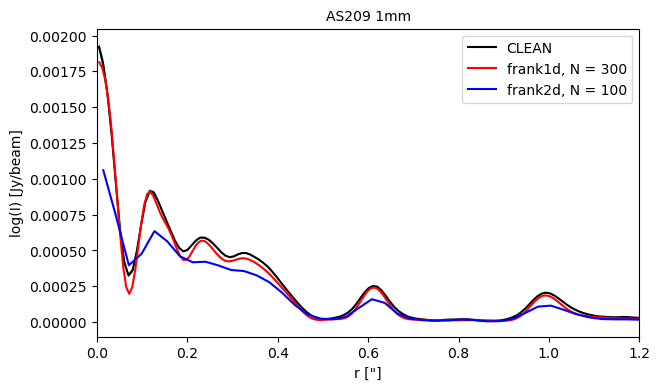

In [313]:
plt.figure(figsize=(7, 4))
plt.plot(x_1mm, y_1mm, "black", label = "CLEAN")
plt.fill_between(x_1mm, y_1mm-dy_1mm, y_1mm+dy_1mm,alpha=0.7)
plt.plot(sol.r, convolved_1mm_frank1d, "red", label=r'frank1d' + ', N = ' +str(n_pts))
plt.plot(r,convolved_1mm_frank2d, "blue", label=r'frank2d' + ', N = ' +str(N))
plt.title(r'AS209 1mm', size=10)
plt.ylabel("log(I) [Jy/beam]", size=10)
plt.xlabel('r ["]', size=10)
plt.legend(fontsize=10)
#plt.yscale('log')
#plt.ylim(0.1e-5, 0.5e-2)
plt.xlim(0,1.2)
plt.show()